In [1]:
# --------------------------------------
# Imports
# --------------------------------------

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from collections import deque
import numpy as np
from moviepy.editor import VideoFileClip
from os.path import join, basename

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pdb

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd
    
import os.path

import random
from sklearn.utils import shuffle
import pdb

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from keras.preprocessing.image import ImageDataGenerator

# Imports for Jupyter
%matplotlib inline



Using TensorFlow backend.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# --------------------------------------
# Helper Functions
# --------------------------------------
def show_image(image, title="One Image", cmap=None, figsize=(14, 9)):
    f, ax1 = plt.subplots(1, 1, figsize=figsize)
    f.suptitle(title, fontsize=16)
    f.tight_layout()
    ax1.imshow(image, cmap=cmap)
    # ax1.set_title('First Image', fontsize=50)
    # ax2.imshow(image2, cmap=cmap2)
    # ax2.set_title('Second Image', fontsize=50)
    # plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


---
## Load Data

In [4]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic_signs_data/train.p"
validation_file= "./traffic_signs_data/valid.p"
testing_file = "traffic_signs_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## 1. Dataset Summary & Exploration

---

### 1.1 Basic Summary

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43
sample_index 151


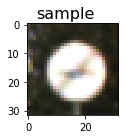

In [5]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

sample_index = random.randint(0, n_train)
sample_image = X_train[sample_index, :, :, :]
image_shape = sample_image.shape

n_classes = np.unique(y_train).shape[0]

sign_names = pd.Series.from_csv("signnames.csv", header=0).to_dict()
sign_names_arr = []
for i in range(len(sign_names)):
    sign_names_arr.append(sign_names[i])

    
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("sample_index", sample_index)
show_image(sample_image, figsize=(2, 2), title="sample")


### 1.2 Visualization

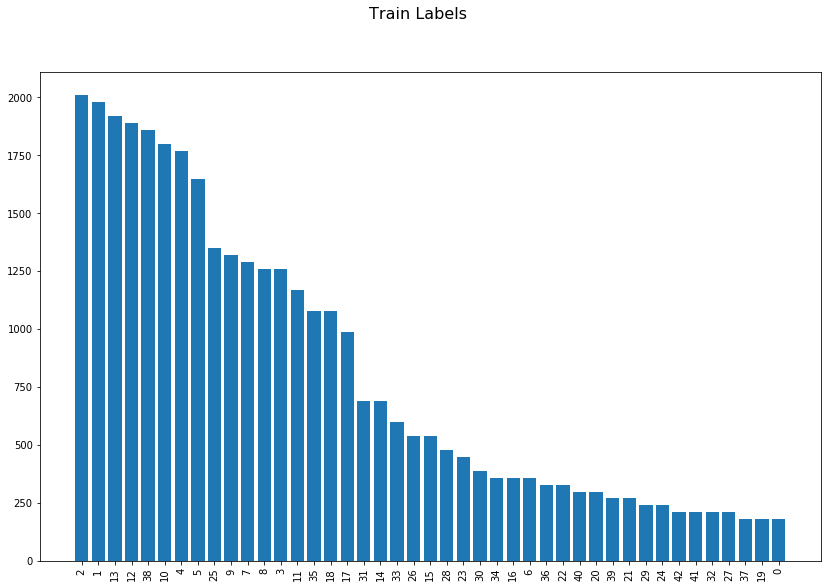

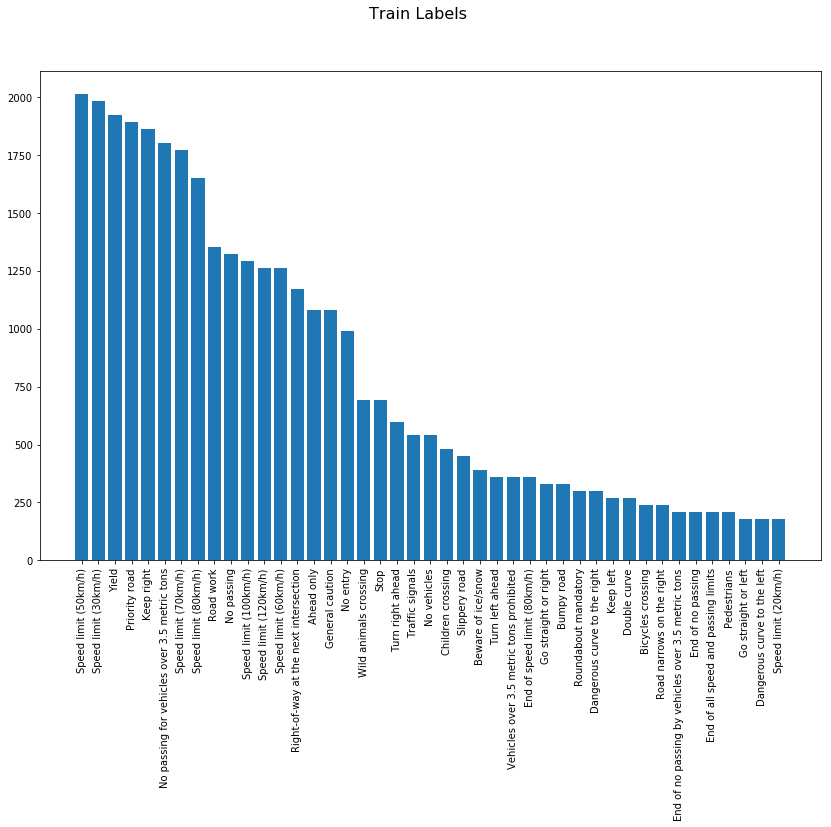

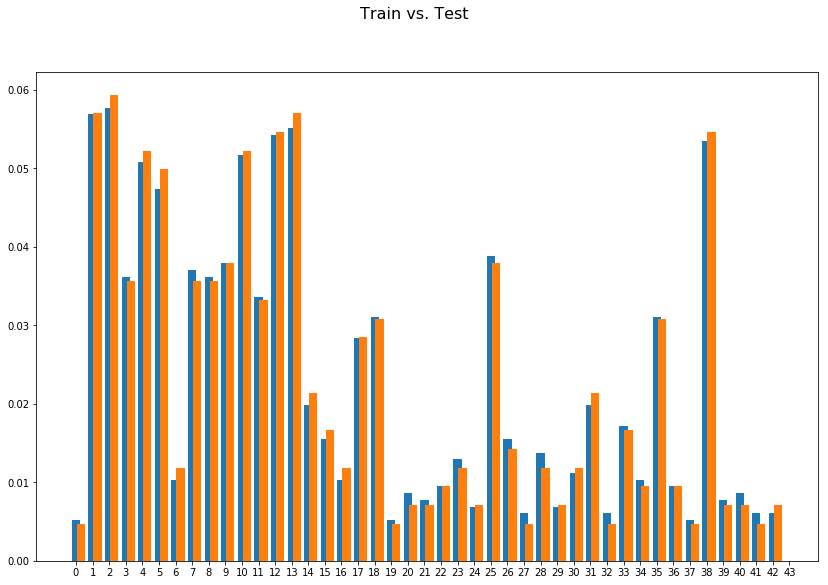

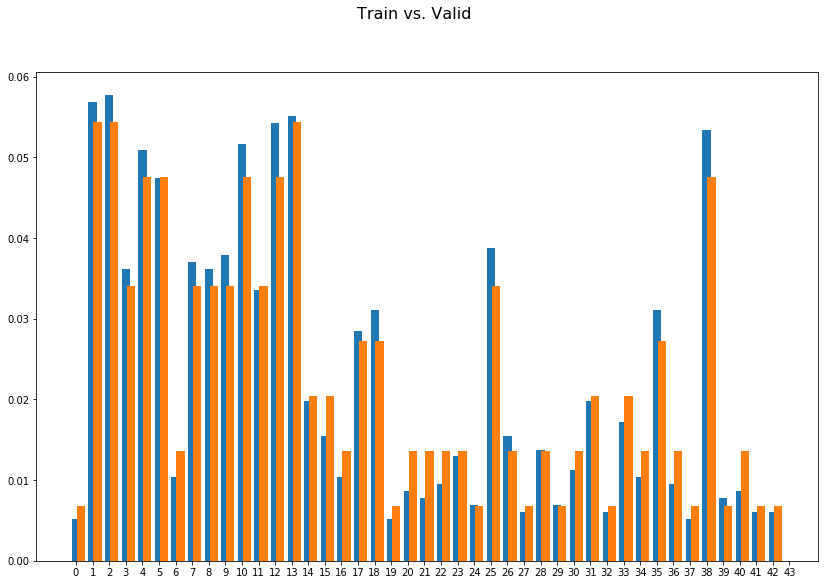

In [174]:
counts = np.unique(y_train, return_counts=True)
counts_test = np.unique(y_test, return_counts=True)
counts_valid = np.unique(y_valid, return_counts=True)

xy = zip(counts[1].tolist(), counts[0].tolist(), sign_names_arr)
xy = sorted(xy)[::-1]
x = [str(a[1]) for a in xy]
z = [a[2] for a in xy]
y = [a[0] for a in xy]

# Histogram of labels
f = plt.figure(figsize=(14,9))
f.suptitle("Train Labels", fontsize=16)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

# Histogram In Text Labels
f = plt.figure(figsize=(14,9))
f.suptitle("Train Labels", fontsize=16)
plt.bar(z, y)
plt.xticks(rotation=90)
plt.show()

# Label Comparison
f = plt.figure(figsize=(14,9))
f.suptitle("Train vs. Test", fontsize=16)
plt.bar(counts[0], counts[1] / sum(counts[1]), width=.5)
plt.bar(counts_test[0] + 0.3, counts_test[1] / n_test, width=.5)
plt.xticks(np.arange(0, len(counts[0])+1, 1.0))
plt.show()

# Label Comparison
f = plt.figure(figsize=(14,9))
f.suptitle("Train vs. Valid", fontsize=16)
plt.bar(counts[0], counts[1] / sum(counts[1]), width=.5)
plt.bar(counts_valid[0] + 0.3, counts_valid[1] / n_valid, width=.5)
plt.xticks(np.arange(0, len(counts[0])+1, 1.0))
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

---

### Preprocess

1. Shuffle the training data.

2. Each image is converted to YUV color space, and we only use the Y channel.

3. I use histogram equalization to imporve contrast of the image. https://docs.opencv.org/3.1.0/d4/d1b/tutorial_histogram_equalization.html

4. I center and scale each pixel by its means and standard deviation.

In [14]:
def shuffle_training_data(X, y):
    return shuffle(X, y)    
    
def preprocess(X):
    new_X = []
    for img in X:
        img = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0], 2)  # Convert to YUV and keep only Y channel
        img = np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) # Improves the contrast 
    
        new_X.append(img)
        
    X = np.array(new_X)
    X = np.float32(X)

    # Standardize
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train, y_train = shuffle(X_train, y_train)
X_train_ = preprocess(X_train)
X_test_ = preprocess(X_test)



# def preprocess_features(X, equalize_hist=True):

#     # convert from RGB to YUV
#     X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

#     # adjust image contrast
#     if equalize_hist:
#         X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X])

#     X = np.float32(X)

#     # standardize features
#     X -= np.mean(X, axis=0)
#     X /= (np.std(X, axis=0) + np.finfo('float32').eps)

#     return X

# X_train_norm = preprocess_features(X_train)
# X_test_norm = preprocess_features(X_test)

# print(X_train_.shape)
# print(X_train.shape)
# print(X_train_norm.shape)


ValueError: Unexpected kw arguments: dict_keys(['n_sample'])

(34799, 32, 32)
(34799, 32, 32, 3)
(34799, 32, 32, 1)


In [16]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)


def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val, shape=shape)
    return tf.Variable(initialization)


def conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)


def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# network architecture definition
def my_net(x, n_classes):

    c1_out = 64
    conv1_W = weight_variable(shape=(3, 3, 1, c1_out))
    conv1_b = bias_variable(shape=(c1_out,))
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)

    pool1 = max_pool_2x2(conv1)

    
    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

    print("\n-----\n")
    print("layer1\n")
    print(conv2d(x, conv1_W))
    print(conv1)
    print(pool1)
    print(drop1)
    print("\n-----\n")
    
    c2_out = 128 * 2
    conv2_W = weight_variable(shape=(3, 3, c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)
    pool2 = max_pool_2x2(conv2)
    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)
    

    print("\n-----\n")
    print("layer2\n")
    print(conv2d(drop1, conv2_W))
    print(conv2)
    print(pool2)
    print(drop2)
    print("\n-----\n")
    
    
    fc0 = tf.concat([flatten(drop1), flatten(drop2)], 1)

    fc1_out = 64
    fc1_W = weight_variable(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    fc2_out = n_classes
    fc2_W = weight_variable(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b
    
    print("\n-----\n")
    print("fanout\n")
    print(fc0)
    print(fc1)
    print(drop_fc1)
    print("\n-----\n")    

    return logits


# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)


# training pipeline
lr = 0.001
logits = my_net(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss_function)


-----

layer1

Tensor("Conv2D_18:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("Relu_14:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("MaxPool_14:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("dropout_21/mul:0", shape=(?, 16, 16, 64), dtype=float32)

-----


-----

layer2

Tensor("Conv2D_20:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("Relu_15:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("MaxPool_15:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("dropout_22/mul:0", shape=(?, 8, 8, 256), dtype=float32)

-----


-----

fanout

Tensor("concat_7:0", shape=(?, 32768), dtype=float32)
Tensor("add_30:0", shape=(?, 64), dtype=float32)
Tensor("dropout_23/mul:0", shape=(?, 64), dtype=float32)

-----



### Model Architecture

In [225]:
def get_w(shape):
    initialization = tf.truncated_normal(shape=shape, mean=0.5, stddev=0.2)
    return tf.Variable(initialization)


def get_bias(shape):
    initialization = tf.constant(value=random.random(), shape=shape)
    return tf.Variable(initialization)


def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# network architecture definition
def build_network(x, n_classes):

    c1_out = 64
    conv1_W = get_w(shape=(3, 3, 1, c1_out))
    conv1_b = get_bias(shape=(c1_out,))
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)

    pool1 = max_pool_2x2(conv1)

    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

    c2_out = 128
    conv2_W = get_w(shape=(3, 3, c1_out, c2_out))
    conv2_b = get_bias(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)

    pool2 = max_pool_2x2(conv2)

    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)

    print(pool1)
    print(drop1)
    print(drop2)
    print([flatten(drop1), flatten(drop2)])
#     fc0 = tf.concat(1, [flatten(drop1), flatten(drop2)])
    fc0 = tf.concat([flatten(drop1), flatten(drop2)], 1)

    fc1_out = 64
    fc1_W = get_w(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = get_bias(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    print(f)

    fc2_out = n_classes
    fc2_W = get_w(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = get_bias(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b

    return logits


# Variables
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)


# training pipeline
lr = 0.001
logits = build_network(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss_function)


# # Metrics
# correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
# accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# def evaluate(X_data, y_data):
    
#     num_examples = X_data.shape[0]
#     total_accuracy = 0
    
#     sess = tf.get_default_session()
#     for offset in range(0, num_examples, BATCHSIZE):
#         batch_x, batch_y = X_data[offset:offset+BATCHSIZE], y_data[offset:offset+BATCHSIZE]
#         accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
#         total_accuracy += accuracy * len(batch_x)
        
#     return total_accuracy / num_examples

# # create a checkpointer to log the weights during training
# checkpointer = tf.train.Saver()

Tensor("MaxPool_53:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("dropout_54/mul:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("dropout_55/mul:0", shape=(?, 8, 8, 128), dtype=float32)
[<tf.Tensor 'Flatten_76/flatten/Reshape:0' shape=(?, 16384) dtype=float32>, <tf.Tensor 'Flatten_77/flatten/Reshape:0' shape=(?, 8192) dtype=float32>]


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
# training hyperparameters
BATCHSIZE = 128
EPOCHS = 30
BATCHES_PER_EPOCH = 5000

image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

print(X_train_.shape)
# start training
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):

        print("EPOCH {} ...".format(epoch + 1))

        batch_counter = 0
        for batch_x, batch_y in image_datagen.flow(X_train_, y_train, batch_size=BATCHSIZE):

            batch_counter += 1
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            if batch_counter == BATCHES_PER_EPOCH:
                break

        # at epoch end, evaluate accuracy on both training and validation set
        train_accuracy = evaluate(X_train_norm, y_train)
        val_accuracy = evaluate(X_val_norm, y_val)
        print('Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}'.format(train_accuracy, val_accuracy))
        
        # log current weights
        checkpointer.save(sess, save_path='../checkpoints/traffic_sign_model.ckpt', global_step=epoch)

(34799, 32, 32, 1)
EPOCH 1 ...


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")